In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import shap

In [2]:
data = pd.read_csv("C:\\Users\\Evelyn Wullar\\Desktop\\MY 2025\\TMP Project\\data\\bank-full.csv", sep=';', quotechar='"')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


EDA

In [3]:
data.shape

(45211, 17)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


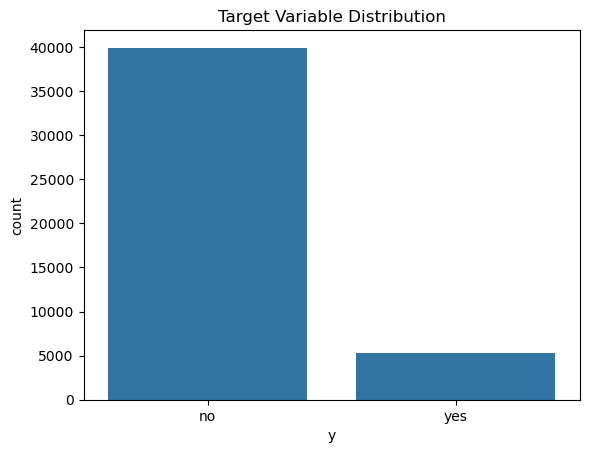

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64


In [7]:
# Distribution of target variable
sns.countplot(data=data, x='y')
plt.title('Target Variable Distribution')
plt.show()

print(data['y'].value_counts(normalize=True))

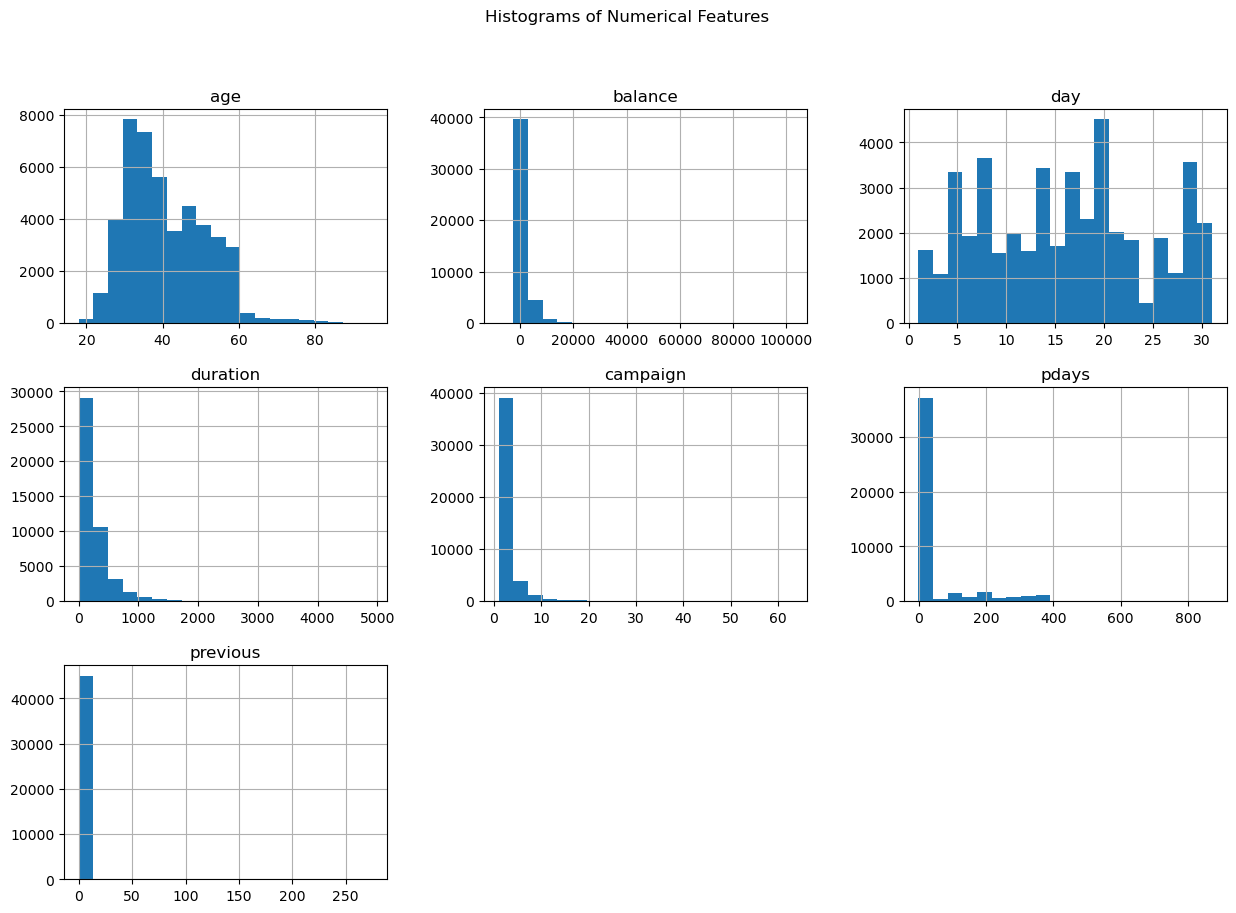

In [8]:
# Distribution of the Numerical columns
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

data[num_cols].hist(figsize=(15, 10), bins=20)
plt.suptitle('Histograms of Numerical Features')
plt.show()


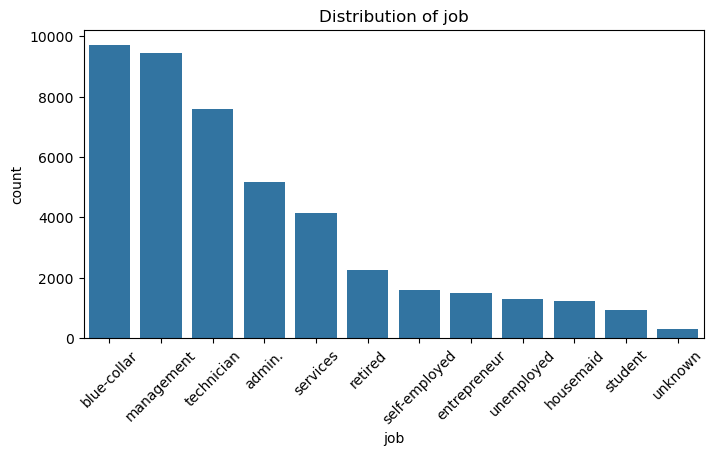

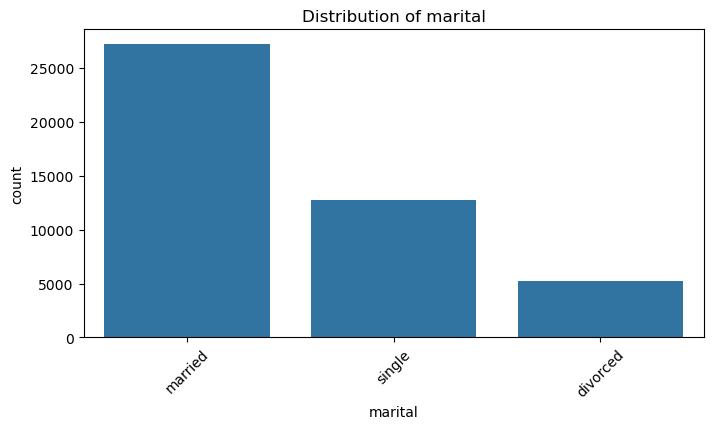

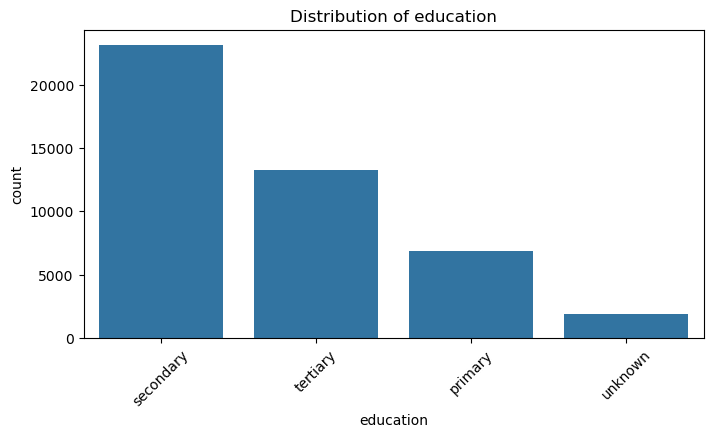

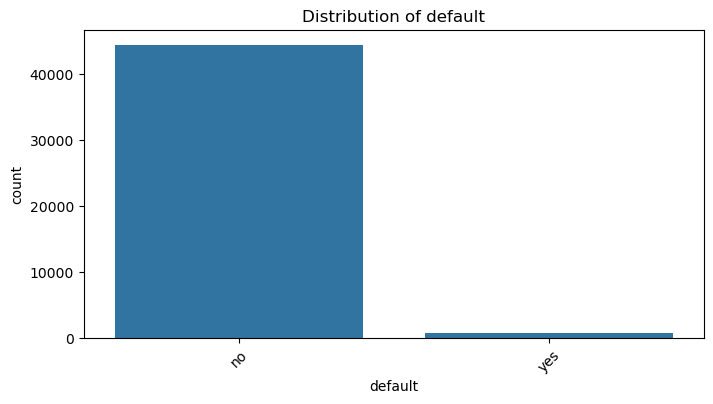

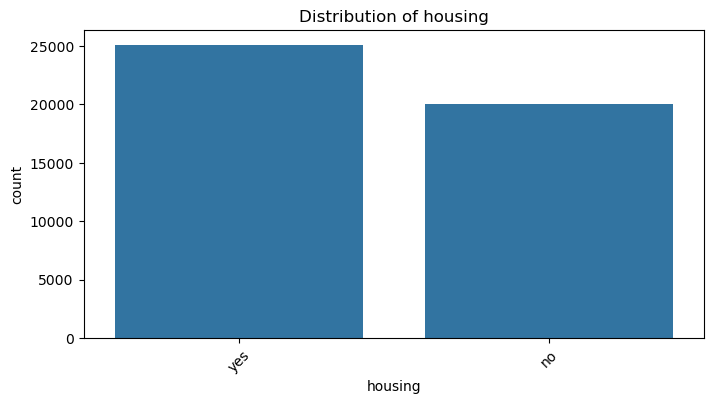

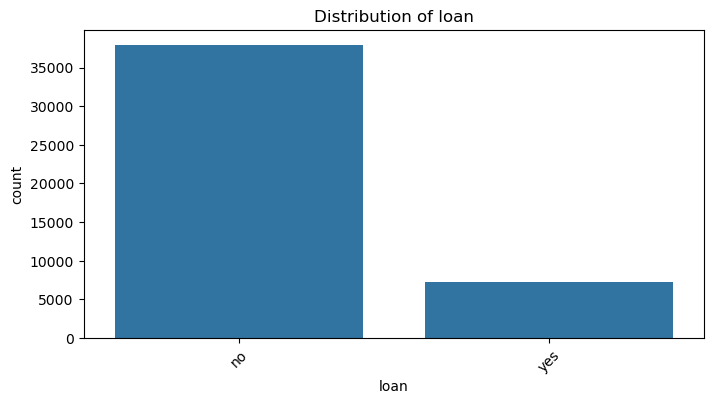

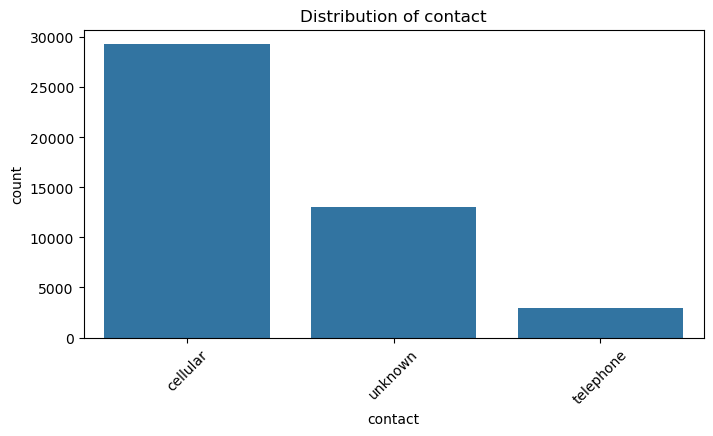

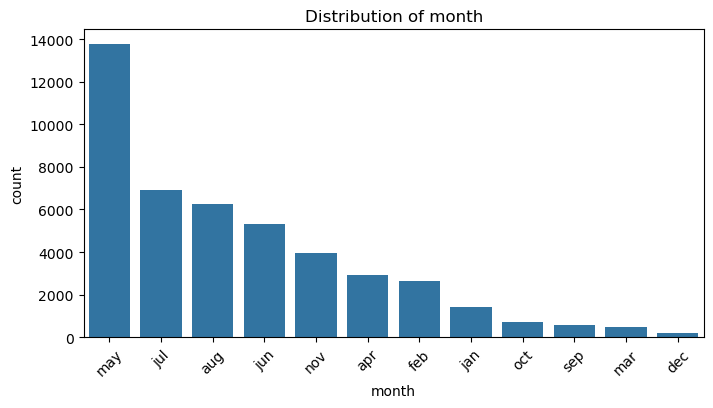

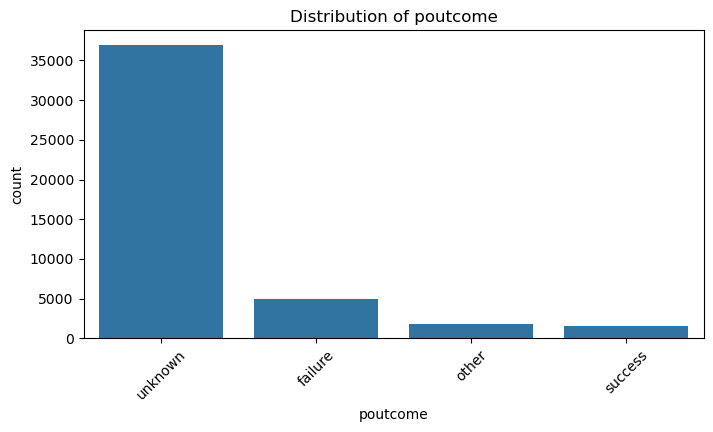

In [9]:
# Distribution of the Categorical columns
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=col, order=data[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()


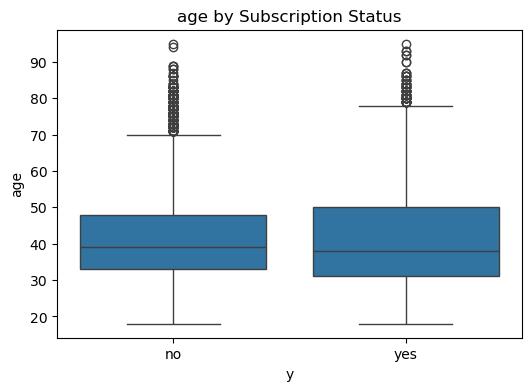

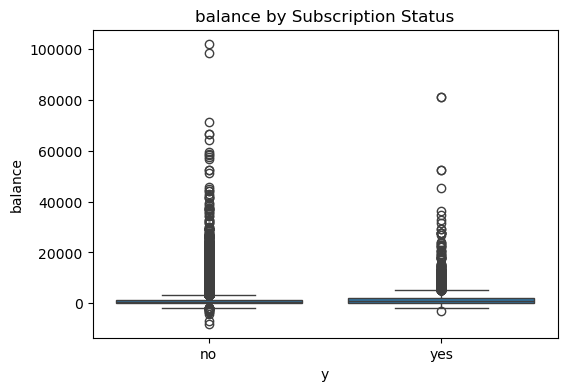

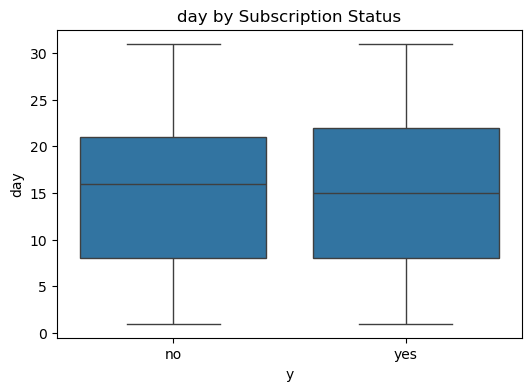

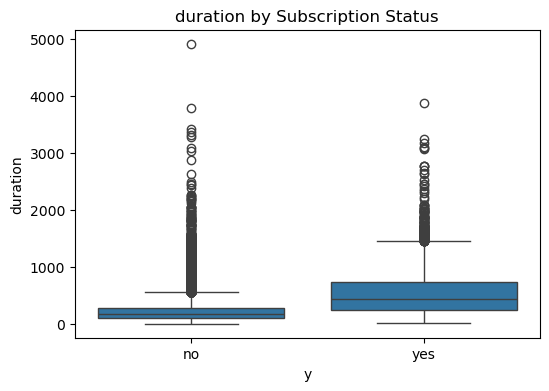

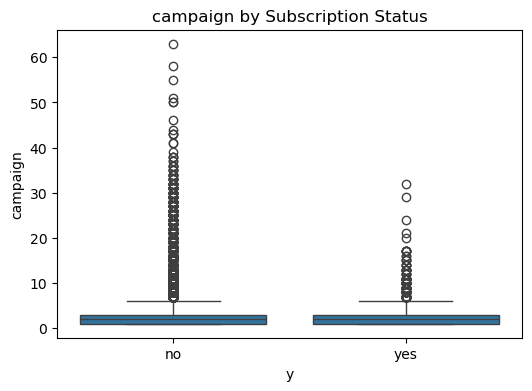

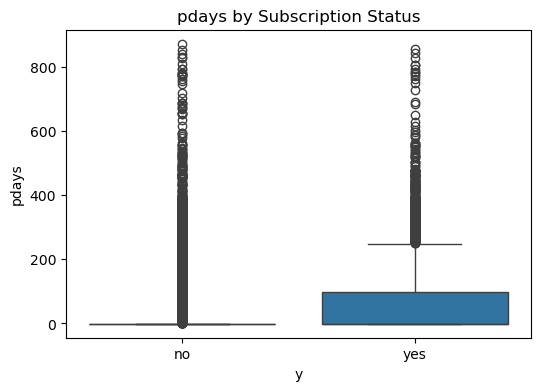

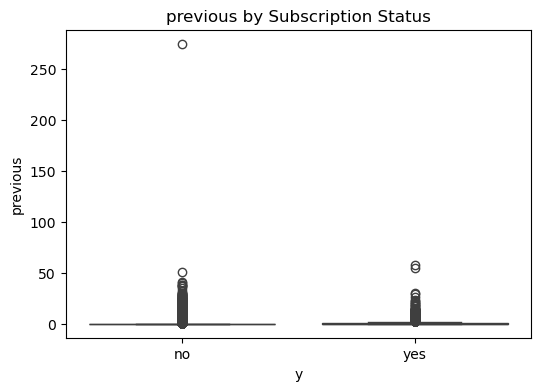

In [10]:
# target vs Numerical Features
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=data, x='y', y=col)
    plt.title(f'{col} by Subscription Status')
    plt.show()


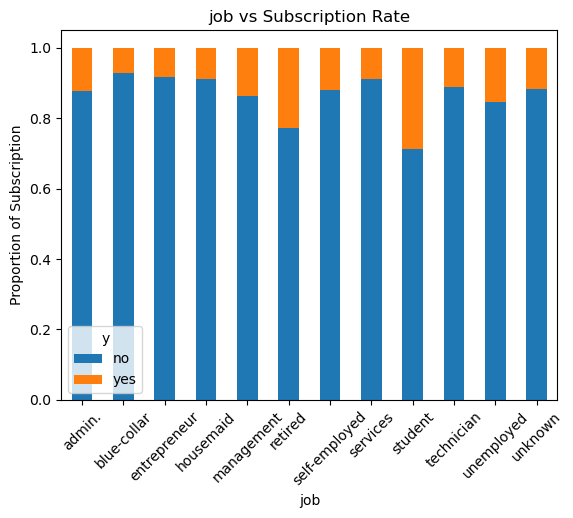

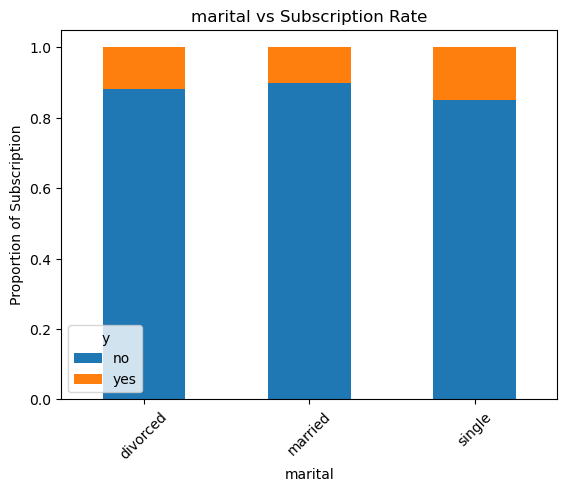

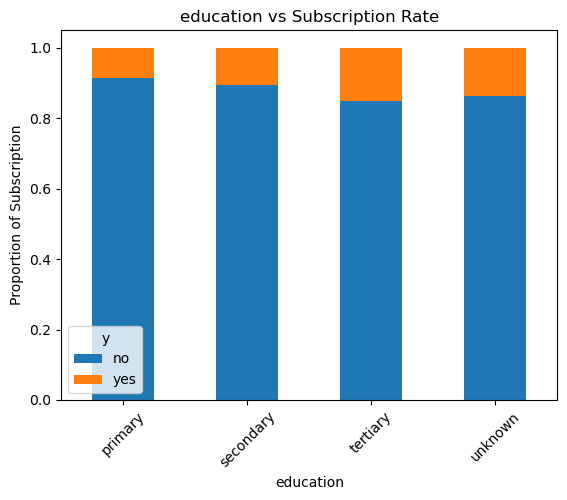

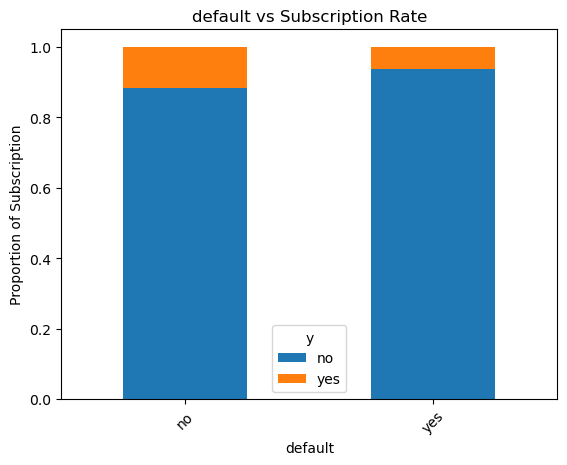

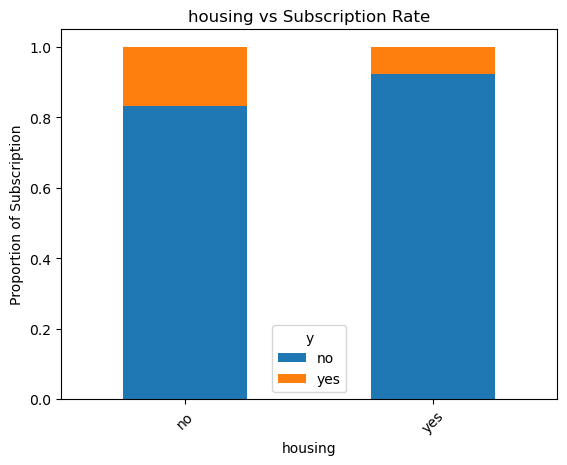

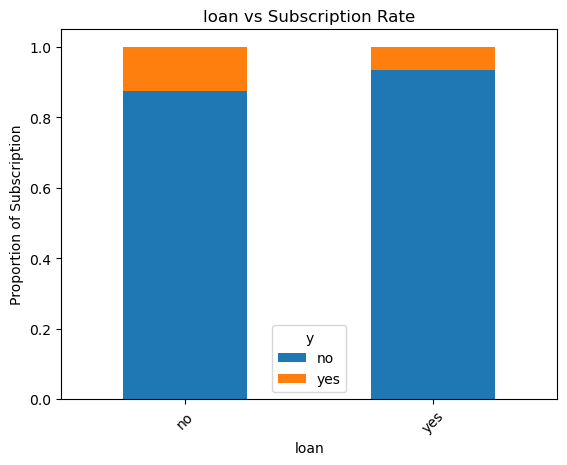

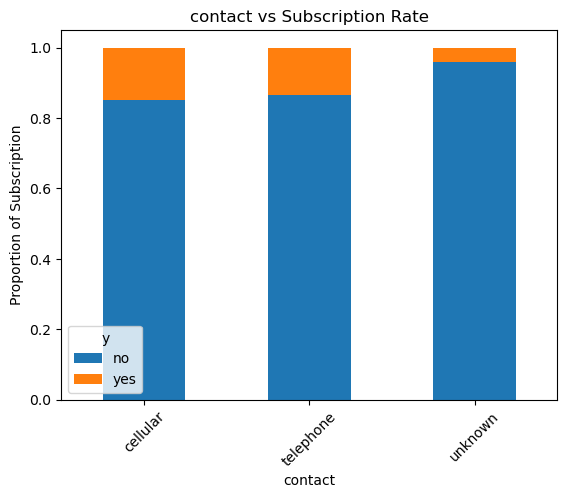

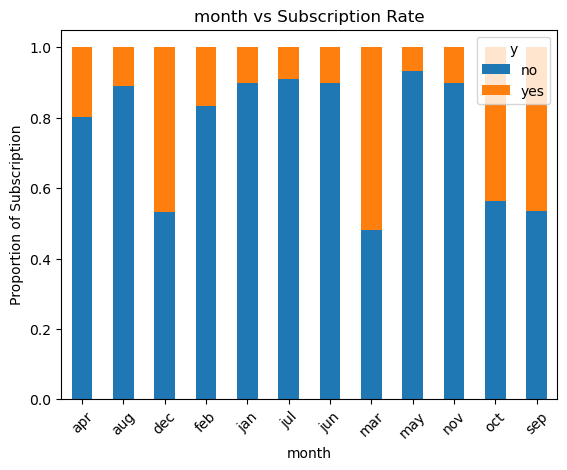

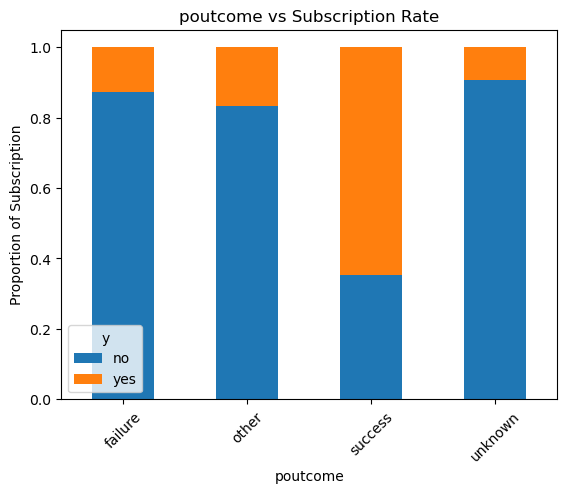

In [11]:
#Target vs Categorical Features
for col in cat_cols:
    pd.crosstab(data[col], data['y'], normalize='index').plot(kind='bar', stacked=True)
    plt.title(f'{col} vs Subscription Rate')
    plt.ylabel('Proportion of Subscription')
    plt.xticks(rotation=45)
    plt.show()


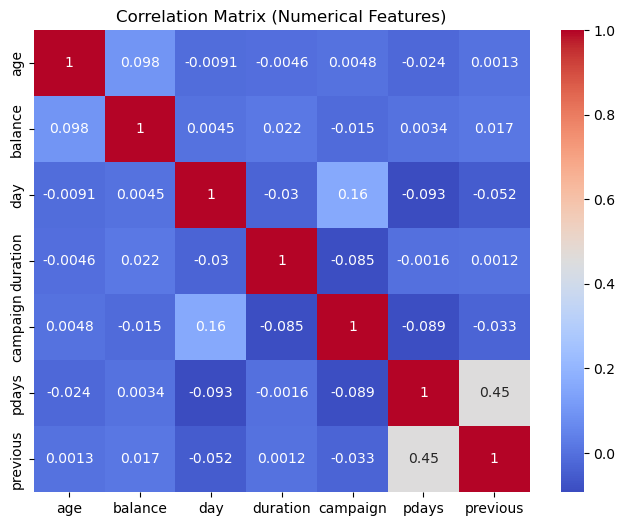

In [12]:
#correlation matrix
corr_matrix = data[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

In [13]:
# Outlier detection
for col in num_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))).sum()
    print(f'{col}: {outliers} outliers')

age: 487 outliers
balance: 4729 outliers
day: 0 outliers
duration: 3235 outliers
campaign: 3064 outliers
pdays: 8257 outliers
previous: 8257 outliers


Data Preprocessing

In [14]:
# dropping duration column
data = data.drop(columns=['duration'])

# clip age at 1st and 99th percentiles
age_lower = data['age'].quantile(0.01)
age_upper = data['age'].quantile(0.99)
data['age'] = data['age'].clip(lower=age_lower, upper=age_upper)

#log transform balance
data['balance'] = np.log1p(data['balance'])

# cap campaign at 99th percentile
campaign_upper = data['campaign'].quantile(0.99)
data['campaign'] = data['campaign'].clip(upper=campaign_upper)


#Feature Creation from pdays and previous(1 if pdays != -1, else 0)
data['pdays_flag'] = np.where(data['pdays'] != -1, 1, 0)
data['previous_flag'] = np.where(data['previous'] > 0, 1, 0)

# Map default, housing, loan, y to 0/1.
data['default'] = data['default'].map({'no': 0, 'yes': 1})
data['housing'] = data['housing'].map({'no': 0, 'yes': 1})
data['loan'] = data['loan'].map({'no': 0, 'yes': 1})
data['y'] = data['y'].map({'no': 0, 'yes': 1})




c:\Users\Evelyn Wullar\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Evelyn Wullar\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


FEATURE ENGINEERING

In [15]:
# binning ages 
bins = [0, 18, 30, 40, 50, 60, 70, 80, np.inf]
data['age_group'] = pd.cut(data['age'], bins=bins, labels=['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+'])
# Drop original age column
data = data.drop(columns=['age'])


In [16]:
# Adding flags for “has missing/unknown info” 
missing_cols = ['job','marital', 'education', 'contact', 'month', 'poutcome']
data['has_missing_info'] = data[missing_cols].isnull().any(axis=1).astype(int)

In [18]:
# One-hot encoding for categorical variables
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

# Combine previous and pdays into new flags
data['previous_pdays_flag'] = np.where((data['previous_flag'] == 1) | (data['pdays_flag'] == 1), 1, 0)

# Create call_frequency_per_month
data['call_frequency_per_month'] = data['campaign'] / 12
# Create a new feature for the ratio of balance to age
data['balance_to_age_ratio'] = data['balance'] / (data['age_group'].cat.codes + 1)  # Avoid division by zero
data.info()
data.to_csv("C:\\Users\\Evelyn Wullar\\Desktop\\MY 2025\\TMP Project\\data\\bank_processed.csv", index=False)

KeyError: "None of [Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',\n       'month', 'poutcome'],\n      dtype='object')] are in the [columns]"

MODEL BUILDING

In [19]:
# loading processed data
newdata = pd.read_csv("C:\\Users\\Evelyn Wullar\\Desktop\\MY 2025\\TMP Project\\data\\bank_processed.csv")


In [20]:
#Model training - train-test split
X = newdata.drop('y', axis=1)
y = newdata['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


1. XGBoost

In [21]:
# Converting 'age_group' to categorical codes for XGBoost compatibility
for df in [X_train, X_test]:
    if 'age_group' in df.columns:
        df['age_group'] = pd.Categorical(df['age_group']).codes

# Replacing inf/-inf with NaN, then fill NaN with 0 for XGBoost compatibility
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

# Model training with XGBoost
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)
model.fit(X_train, y_train)


c:\Users\Evelyn Wullar\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:31:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [22]:
# model evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


[[7861  124]
 [ 813  245]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.66      0.23      0.34      1058

    accuracy                           0.90      9043
   macro avg       0.79      0.61      0.64      9043
weighted avg       0.88      0.90      0.87      9043

ROC AUC Score: 0.8037391706803755


 95%|=================== | 8609/9043 [00:17<00:00]       

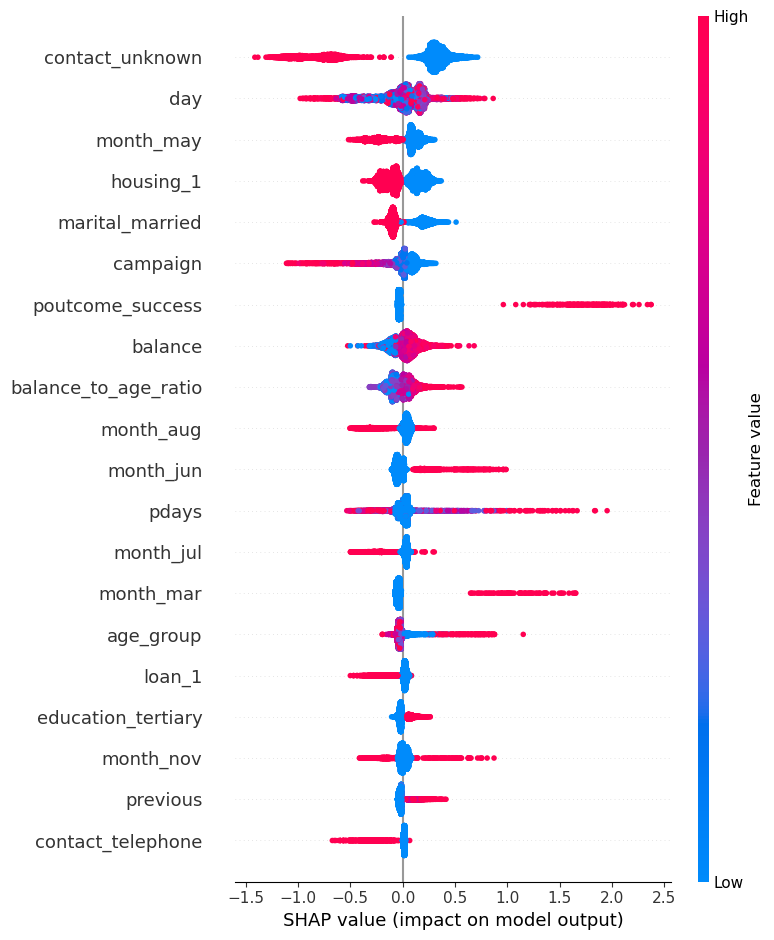

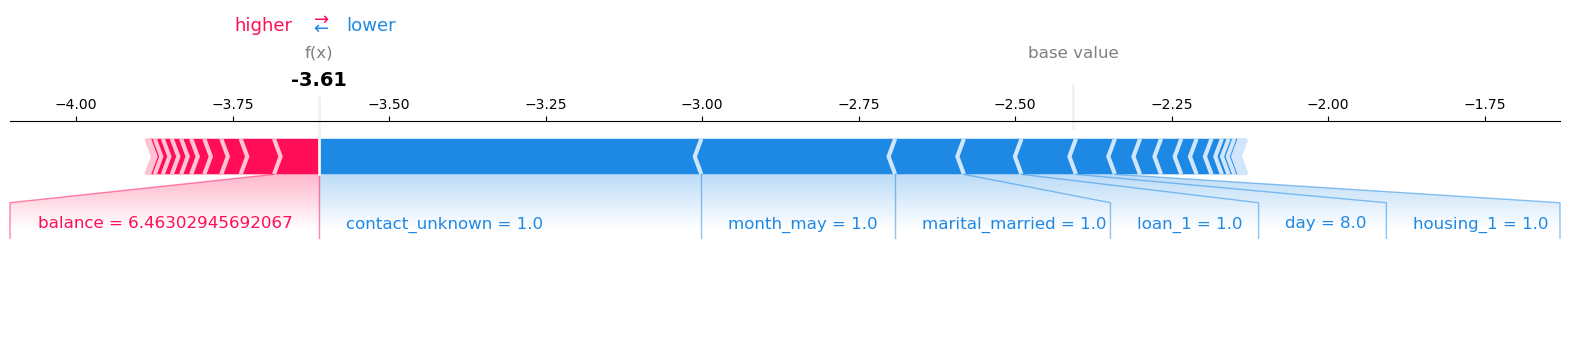

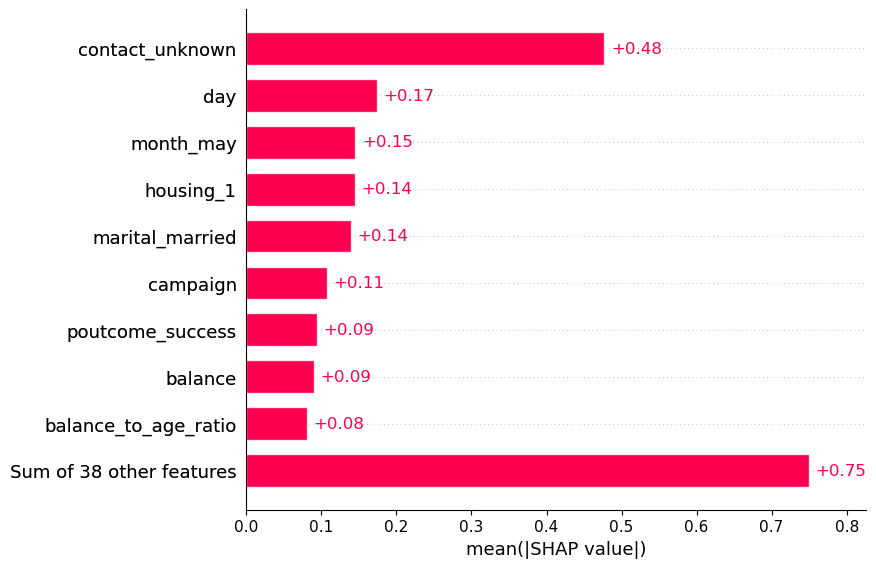

In [23]:
# SHAP values for model interpretability

import shap

# Convert all boolean columns to int for SHAP compatibility
X_train_shap = X_train.copy()
X_test_shap = X_test.copy()
for df in [X_train_shap, X_test_shap]:
	bool_cols = df.select_dtypes(include=['bool']).columns
	df[bool_cols] = df[bool_cols].astype(int)
	# If any object/category columns remain, convert to codes
	for col in df.select_dtypes(include=['object', 'category']).columns:
		df[col] = pd.Categorical(df[col]).codes

# SHAP Explainer
explainer = shap.Explainer(model, X_train_shap)
shap_values = explainer(X_test_shap)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test_shap)

# Force plot for a single prediction (use .values and .base_values for the first sample)
shap.force_plot(
	shap_values.base_values[0],
	shap_values.values[0],
	X_test_shap.iloc[0],
	matplotlib=True
)

# Feature importance plot
shap.plots.bar(shap_values, max_display=10)  # Top 10




Model Improvement

In [24]:
# Class distribution and scale_pos_weight calculation
from collections import Counter

# Check class distribution
counter = Counter(y_train)
neg, pos = counter[0], counter[1]
scale_pos_weight = neg / pos

print(f"Class 0: {neg}, Class 1: {pos}, scale_pos_weight: {scale_pos_weight:.2f}")


Class 0: 31937, Class 1: 4231, scale_pos_weight: 7.55


In [25]:
# Model training with scale_pos_weight for imbalanced data
from xgboost import XGBClassifier

model_weighted = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)

model_weighted.fit(X_train, y_train)


c:\Users\Evelyn Wullar\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:32:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model_weighted.predict(X_test)
y_prob = model_weighted.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


[[6715 1270]
 [ 380  678]]
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      7985
           1       0.35      0.64      0.45      1058

    accuracy                           0.82      9043
   macro avg       0.65      0.74      0.67      9043
weighted avg       0.88      0.82      0.84      9043

ROC AUC Score: 0.8045866955172328


 99%|===================| 8990/9043 [00:17<00:00]        

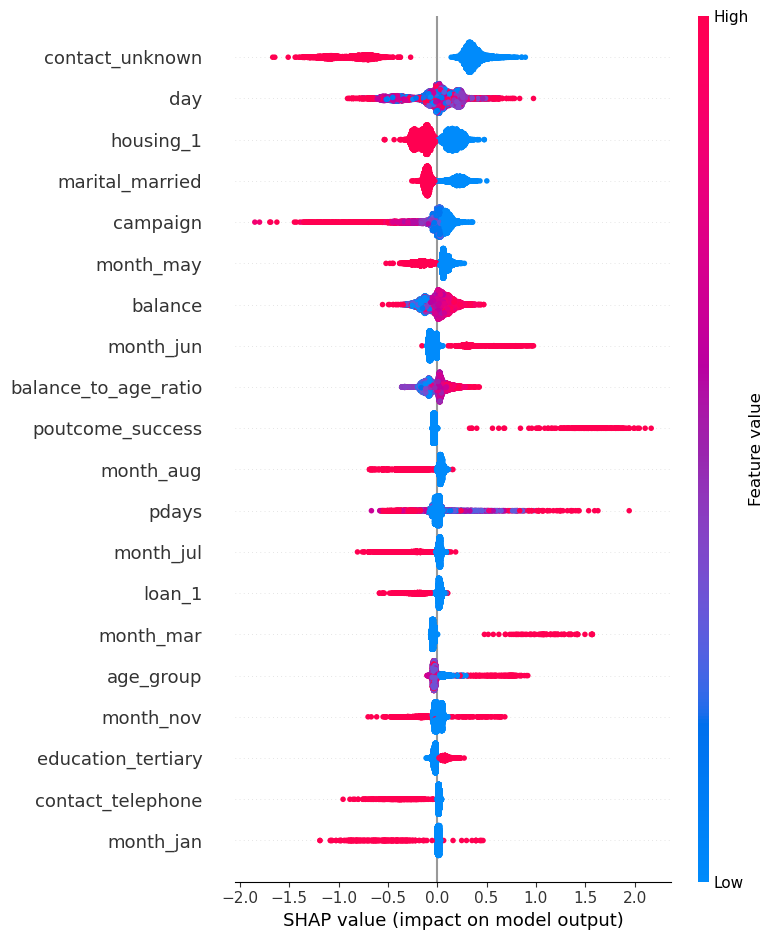

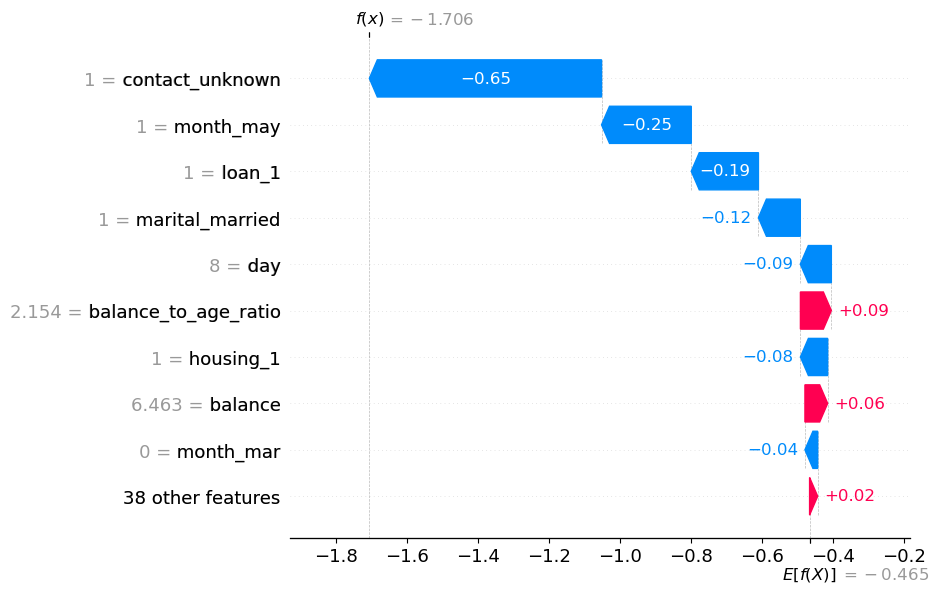

In [27]:
# SHAP values for model interpretability with weighted model

# Use the numeric/categorical-code versions for SHAP
explainer = shap.Explainer(model_weighted, X_train_shap)

# Calculate SHAP values for test set
shap_values = explainer(X_test_shap)

# Global summary plot
shap.summary_plot(shap_values, X_test_shap)

# Individual prediction explanation (e.g., first row)
shap.plots.waterfall(shap_values[0])


In [28]:
# Hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'scale_pos_weight': [scale_pos_weight]  # keep it fixed for now
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                    param_grid=params,
                    scoring='roc_auc',
                    cv=3,
                    verbose=1,
                    n_jobs=-1)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
best_model = grid.best_estimator_


Fitting 3 folds for each of 18 candidates, totalling 54 fits


c:\Users\Evelyn Wullar\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 7.548333727251241}


2. Logistic Regression & Random Forest Models

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib

# Logistic Regression with balanced class weights
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)


c:\Users\Evelyn Wullar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier(class_weight='balanced', random_state=42)

In [30]:
# Evaluating the models 

def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n{name} Evaluation")
    print("-" * 30)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

evaluate_model(log_model, X_test, y_test, "Logistic Regression")
evaluate_model(rf_model, X_test, y_test, "Random Forest")



Logistic Regression Evaluation
------------------------------
Confusion Matrix:
[[6165 1820]
 [ 381  677]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      7985
           1       0.27      0.64      0.38      1058

    accuracy                           0.76      9043
   macro avg       0.61      0.71      0.61      9043
weighted avg       0.86      0.76      0.79      9043

ROC AUC Score: 0.7747

Random Forest Evaluation
------------------------------
Confusion Matrix:
[[7864  121]
 [ 845  213]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7985
           1       0.64      0.20      0.31      1058

    accuracy                           0.89      9043
   macro avg       0.77      0.59      0.62      9043
weighted avg       0.87      0.89      0.87      9043

ROC AUC Score: 0.7774


In [31]:
# Saving the model and features
import joblib

joblib.dump(model_weighted, 'term_deposit_model.pkl')
joblib.dump(X_train.columns.tolist(), 'model_features.pkl')  


['model_features.pkl']

In [32]:
# Loading the saved model and features
model = joblib.load('term_deposit_model.pkl')
features = joblib.load('model_features.pkl')


In [41]:
import joblib
features = joblib.load("C:\\Users\\Evelyn Wullar\\Desktop\\MY 2025\\TMP\\TMP PROJECT\\term_deposit_api\\model\\model_features.pkl")
print(features)

['balance', 'day', 'campaign', 'pdays', 'previous', 'pdays_flag', 'previous_flag', 'age_group', 'has_missing_info', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_1', 'housing_1', 'loan_1', 'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'previous_pdays_flag', 'call_frequency_per_month', 'balance_to_age_ratio']
